In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Introduction

This is my submission for the Deep Learning Course week 3. In this project, I'm going to inspect the Histopathologic Cancer Detection dataset, and create a deep learning model to analyse that.

In [3]:
!kaggle competitions download -c histopathologic-cancer-detection

zsh:1: command not found: kaggle


First, loading and viewing the labels.

In [4]:
labels = pd.read_csv('kaggle/input/histopathologic-cancer-detection/train_labels.csv')

In [5]:
print(labels.head())
print(labels.describe())
labels.isnull().sum()

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
               label
count  220025.000000
mean        0.405031
std         0.490899
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000


id       0
label    0
dtype: int64

Based on the initial EDA, we can determine that this is a classification problem, and the ids possibly correspont to images.

### Loading the train and test data

I used `pathlib` to load the train and test data.

In [6]:
import pathlib

train_path = 'kaggle/input/histopathologic-cancer-detection/train/'
test_path = 'kaggle/input/histopathologic-cancer-detection/test/'
train_dir = pathlib.Path(train_path).with_suffix('')
test_dir = pathlib.Path(test_path).with_suffix('')

train_imgs = list(train_dir.glob('*.tif'))
test_imgs = list(test_dir.glob('*.tif'))

print(len(train_imgs))
print(len(test_imgs))

220025
57458


Now, we need to get all the files

In [7]:
import os

train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

print('Training image files: ')
print(train_files[:10])
print('Testing image files: ')
print(test_files[:10])




Training image files: 
['f0c2a0b8ef3024f407fa97d852d49be0215cafe0.tif', '99ef485f205645918613cd04281098daa7c17819.tif', 'e2612e173abd0e8bb54a3c3db3f264b63d80bffb.tif', '6d1bb57c0606f05dbd75f90a8d9e21a57e1267e0.tif', '9c043ab2adadfeb758c71d21432fccd3e43565c0.tif', '9cc775713dd09351172a350871a547346af08027.tif', '1996c210f020134e986823ca7d4df0a70a799c34.tif', '270d16e6b9d88f09f3cc2e538f23091b186a33e5.tif', '731fe361f4af33b5e4f11d74b2bc7508171904e6.tif', 'c7cf86c53ef00698e1e46f430e8527b534bd0368.tif']
Testing image files: 
['fd0a060ef9c30c9a83f6b4bfb568db74b099154d.tif', '1f9ee06f06d329eb7902a2e03ab3835dd0484581.tif', '19709bec800f372d0b1d085da6933dd3ef108846.tif', '7a34fc34523063f13f0617f7518a0330f6187bd3.tif', '93be720ca2b95fe2126cf2e1ed752bd759e9b0ed.tif', '761dde7de22cb39a0dd67ce472163d66e5ac1568.tif', '58055ce8819717a100b48d019e139be4fdf997c0.tif', '9735b584631f4b942b022d40aecdbe2aa8f6ae5e.tif', '860bbd33f8483a45858c4998021bc7434117deda.tif', '99050fbce64ae16e48e8a3b09d38f3b16df63fbe

At this stage, I belive we should visualize the images to get a sense of how to approach them. Based on the dataset description, 1 indicates that the image has a tumor tissue, and 0 means it doesn't have a tumor tissue.

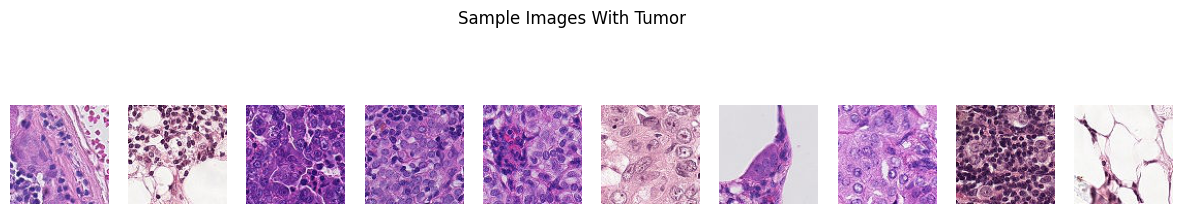

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
samples = labels[labels['label'] == 1].sample(10)
plt.figure(figsize=(15, 3))
for idx, img_name in enumerate(samples['id']):
    img_path = os.path.join(train_dir, img_name + '.tif')
    img = Image.open(img_path)
    plt.subplot(1, 10, idx+1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle(f'Sample Images With Tumor')
plt.show()

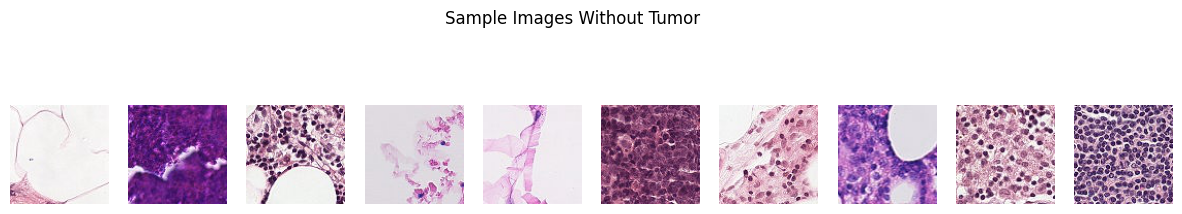

In [9]:
samples = labels[labels['label'] == 0].sample(10)
plt.figure(figsize=(15, 3))
for idx, img_name in enumerate(samples['id']):
    img_path = os.path.join(train_dir, img_name + '.tif')
    img = Image.open(img_path)
    plt.subplot(1, 10, idx+1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle(f'Sample Images Without Tumor')
plt.show()

## Phase 2: Building the model
Based on our initial understanding of the data, we need to do image processing. The best way to do image processing in deep learning is by using Convolutional Neural Networks (CNNs)


In [10]:
import tensorflow as tf
import keras
from keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to true, if needed
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print("exception: ", e)
else:
    print("No GPU found.")

1 Physical GPUs, 1 Logical GPUs


2024-11-14 11:43:58.934856: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-11-14 11:43:58.934887: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-11-14 11:43:58.934893: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-11-14 11:43:58.934909: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-14 11:43:58.934920: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In this model, we start with an input shape of 96 by 96px across 3 dimensions (color channels). Then use (conv, maxpoolin)n layers. Finally, since it's a binary classification problem, we use sigmoid (we could use softmax too, but sigmoid seems more suitable).

In [11]:
config = [Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
          MaxPooling2D(2,2),
          
          Conv2D(64, (3,3), activation='relu'),
          MaxPooling2D(2,2),

          Conv2D(64, (3,3), activation='relu'),
          MaxPooling2D(2,2),
          
          Flatten(),
          Dense(128, activation='relu'),
          Dense(1, activation='sigmoid')]

model = Sequential(config)

/opt/anaconda3/envs/tf-3-9/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


For hyperparameters, I used learning rate (alpha) of 0.005, and I used Adam optimizer. 

In [12]:
learning_rate = 0.005
opt = keras.optimizers.Adam(learning_rate = learning_rate)
model.compile(optimizer = opt,
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 875,777 (3.34 MB)

 Trainable params: 875,777 (3.34 MB)

 Non-trainable params: 0 (0.00 B)

Now, we split the dataset

In [13]:
from sklearn.model_selection import train_test_split

train_labels, val_labels = train_test_split(labels,
                                            test_size = 0.2,
                                            random_state = 0)

In [14]:
train_labels.head()

,id,label
205571,a42ed368dfea7e31fcde574fc9ab5ec921642cd4,1
18438,54946370aec5fe50c6c8595e880f58051445b007,1
47235,a1091dc4027ac7fb5d6fdd96c6b3d3571c6adbdf,1
42780,09afaac18518e435c68fc1b635690c79b52d1a0e,0
70202,8ab7670b07494ca3b51b570fc243467a7a45895c,1


Next, combine the filename with the extension to make things easier.

In [15]:
train_labels['label'] = train_labels['label'].astype(str)
val_labels['label'] = val_labels['label'].astype(str)
train_labels['filename'] = train_labels['id'] + '.tif'
val_labels['filename'] = val_labels['id'] + '.tif'

image_size = (96, 96)

In [16]:
train_labels.head()

,id,label,filename
205571,a42ed368dfea7e31fcde574fc9ab5ec921642cd4,1,a42ed368dfea7e31fcde574fc9ab5ec921642cd4.tif
18438,54946370aec5fe50c6c8595e880f58051445b007,1,54946370aec5fe50c6c8595e880f58051445b007.tif
47235,a1091dc4027ac7fb5d6fdd96c6b3d3571c6adbdf,1,a1091dc4027ac7fb5d6fdd96c6b3d3571c6adbdf.tif
42780,09afaac18518e435c68fc1b635690c79b52d1a0e,0,09afaac18518e435c68fc1b635690c79b52d1a0e.tif
70202,8ab7670b07494ca3b51b570fc243467a7a45895c,1,8ab7670b07494ca3b51b570fc243467a7a45895c.tif


rescale and normalize

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=image_size,
    batch_size=32,
    class_mode='binary')

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_labels,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=image_size,
    batch_size=32,
    class_mode='binary')

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


Next, let's run the model to get a sense of how its performing. I selected 20 epochs to train it.

In [18]:
initial_result = None
if os.path.exists('model.h5'):
    model = models.load_model('model.h5')
else:
    initial_result = model.fit(train_generator,
                    epochs = 20,
                    validation_data = val_generator)
    initial_result
    model.save('model.h5')

In [19]:
# evaluate the model
test_loss, test_acc = model.evaluate(val_generator, verbose=2)

print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)


/opt/anaconda3/envs/tf-3-9/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-11-14 11:44:03.633663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1376/1376 - 17s - 12ms/step - accuracy: 0.9389 - loss: 0.1608

Test accuracy: 0.9388706088066101

Test loss: 0.16082248091697693


In [20]:
def learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 10))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    

In [21]:
if initial_result != None:
    learning_curve(initial_result)

As you can see, the test loss (validation) and accuracy is acceptable. But we can tune the model further. To fine tune the model, I added more layers, batch normalization, and dropout. Also to stop model when we have reached the optimal loss, I used early stopping.

In [22]:
from keras.callbacks import EarlyStopping

config_2 = [Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3), kernel_initializer='he_normal'),
            BatchNormalization(),
            MaxPooling2D(2,2),
            
            Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal'),
            BatchNormalization(),
            MaxPooling2D(2,2),
            
            Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal'),
            BatchNormalization(),
            MaxPooling2D(2,2),
            
            Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal'),
            BatchNormalization(),
            MaxPooling2D(2,2),
            
            Flatten(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')]


if os.path.exists('model2.h5'):
    model_2 = models.load_model('model2.h5')
else:
    model_2 = Sequential(config_2)
    learning_rate = 0.0001
    opt = keras.optimizers.Adam(learning_rate = learning_rate)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_2.compile(optimizer = opt,
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy'])
    result_2 = model_2.fit(train_generator,
                    epochs = 20,
                    validation_data = val_generator,
                    callbacks = [early_stopping])
    model_2.save('model2.h5')


/opt/anaconda3/envs/tf-3-9/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
# evaluate the model
val_loss, val_acc = model_2.evaluate(val_generator, verbose=2)
print('\nTest accuracy:', val_acc)
print('\nTest loss:', val_loss)


1376/1376 - 17s - 12ms/step - accuracy: 0.9331 - loss: 0.1779

Test accuracy: 0.9330757856369019

Test loss: 0.17787471413612366


In [28]:
test_files = os.listdir(test_dir)
predictions = []

# Process images in batches
batch_size = 32
for i in range(0, len(test_files), batch_size):
    batch_files = test_files[i:i + batch_size]
    batch_images = []
    
    # Load and preprocess each image in the batch
    for filename in batch_files:
        img_path = os.path.join(test_dir, filename)
        img = tf.keras.utils.load_img(img_path, target_size=image_size)
        img_array = tf.keras.utils.img_to_array(img)
        img_array = img_array / 255.0  # Rescale
        batch_images.append(img_array)
    

    batch_images = np.array(batch_images)
    batch_predictions = model_2.predict(batch_images, verbose=0)
    predictions.extend(batch_predictions.flatten())


submission_df = pd.DataFrame({
    'id': [f.replace('.tif', '') for f in test_files],
    'label': (np.array(predictions) > 0.5).astype(int)
})

# Save submission
submission_df.to_csv('submission_model_2.csv', index=False)